# Deep Q Network with Pong

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels. The main parts of the DQN are Q learning, the neural net, experience replay, target network updating, and data/environment pre-processing.


### Import Libraries

In [1]:
# Elsa Anza Martín (21272808) Albert Martínez (21251266) Kong Sheng Loi (21077363)
# The code executes to the end without errors.
# This code is taken and adapted from https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%203/3.7%20Dueling%20DQN%20with%20Pong.ipynb

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

from collections import deque
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

In [2]:
# Run this asap since it takes 30 seconds
%%capture
!apt-get update
!pip install pyglet==1.3.2
!pip install gym[atari] pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!pip install tensorflow==2.1.*
!pip install box2d-py
!pip install gast==0.2.2
from gym import logger as gymlogger
from gym.wrappers import Monitor
import tensorflow as tf
import random
import glob
import io
import time
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Download and install the ROM content from the internet
!pip install unrar
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-04-22 13:27:29--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.68M   721KB/s    in 27s     

2022-04-22 13:27:57 (701 KB/s) - ‘Roms.rar’ saved [19583716/19583716]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin          0%  OK 
Extracting  /content/ROM/2 in 1 - Chess, Othello (Atari) (Prototype).bin       0%  OK 
Extracting  /content/ROM/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) (PAL).bin       0%  OK 
Extracting  /content/ROM/2 Pak Special - Challenge, Surfing (1990) (HES) (771-333) (PAL).b

### Experience Replay Buffer

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, done condition, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples. The replay buffer is essentially a queue that we randomly sample from. When the queue gets full we replace the first element of the queue. 

In [5]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### Environment Wrappers

Wrappers modify gym environments. Wrappers can change the observation, reward, done, and info returns. Wrappers can also change the gym functions like step() and reset(). We include and use some common wrappers used in Atari games in the cells below. To use a wrapper, feed the gym env into the wrapper function like in the next cell. Sometimes problems require their own customized wrappers.

In [11]:
# from: https://github.com/openai/baselines/baselines/common/atari_wrappers.py
# from: https://github.com/Officium/RL-Experiments/blob/master/src/common/wrappers.py 

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few
            # frames so it's important to keep lives > 0, so that we only reset
            # once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = info = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, self.height, self.width)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=np.uint8
        )

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        size = (self.width, self.height)
        frame = frame[34: -16, :] # remove irrelevant parts
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also `LazyFrames`
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        shape = (shp[0] * k, ) + shp[1:]
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=env.observation_space.dtype
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are
        only stored once. It exists purely to optimize memory usage which can be
        huge for DQN's 1M frames replay buffers.
        This object should only be converted to numpy array before being passed
        to the model. You'd not believe how complex the previous solution was.
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]
    
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=84, height=84)
    env = MaxAndSkipEnv(env, skip=4)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

### Pong

In this notebook we'll train an agent to play the classic Atari game Pong. In Pong the agent controls a paddle and tries to hit a ball past the opponents paddle to score a point. The agent gets a positive reward when scoring a point and a negative reward when the opponent scores a point. The episode ends when a set number of points are reached.

In [7]:
#create Pong env and test it a bit
env = gym.make('PongNoFrameskip-v4')
env.reset()

for i in range(3000):
    env.render("rgb_array")
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    if done:
        env.reset()
env.close()

n_actions = env.action_space.n
state_dim = env.observation_space.shape

print('The original number of state features: {}'.format(state_dim))
print('Number of possible actions: {}'.format(n_actions))

The original number of state features: (210, 160, 3)
Number of possible actions: 6


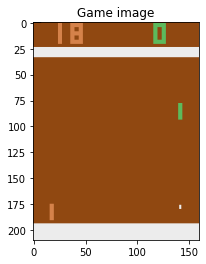

In [8]:
# review Original Pong Atari image
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

### Processing game image

In [12]:
# Define a function to process the game image
def make_env():
    env = gym.make("PongNoFrameskip-v4")
    env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True)
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
action_size = env.action_space.n
state_dim = env.observation_space.shape

print('Number of state features: {}'.format(state_dim))
print('Number of possible actions: {}'.format(action_size))

Number of state features: (4, 84, 84)
Number of possible actions: 6


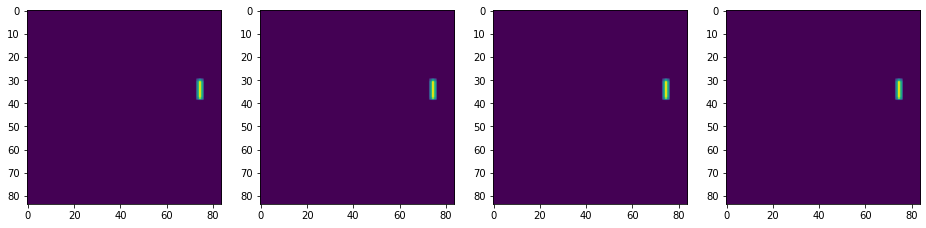

In [13]:
# Observation of the game after image processing
n_cols = 4
n_rows = 1
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :])
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Deep Q Network

The Deep Q Network is from the original DQN paper and is sometimes referred to as the Nature CNN (since the article was published in Nature). Compared to state of the art CNNs in image recognition, the Nature CNN is quite simple. There are only three convolutional layers, followed by a fully connected (dense) layer and a linear layer. All but the linear layer have ReLU activations.

In [ ]:
# based on Nature CNN from OpenAI baselines: https://github.com/openai/baselines/blob/1b092434fc51efcb25d6650e287f07634ada1e08/baselines/common/models.py

class DeepQNetwork(nn.Module):
    def __init__(self, action_size, hidden_size):
        super(DeepQNetwork, self).__init__()
         # The first hidden layer convolves 32 8×8 filters with stride 4
        self.conv_layer_1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)

        # The second hidden layer convolves 64 4×4 filters with stride 2
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # The third hidden layer convolves 64 3x3 filters with stride 1
        self.conv_layer_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Fully connected layer made up of 512 rectifier units.
        self.dense_layer = nn.Linear(7 * 7 * 64, hidden_size)

        # The output layer is a fully-connected linear layer with a single output for each valid action."
        self.out_layer = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = x / 255. # image data is stored as ints in 0 to 255 range. Divide to scale to 0 to 1 range
        x = F.relu(self.conv_layer_1(x))
        x = F.relu(self.conv_layer_2(x))
        x = F.relu(self.conv_layer_3(x))
        x = F.relu(self.dense_layer(x.view(x.size(0), -1)))
        return self.out_layer(x)

### DQNAgent Class

We create a DQNAgent class. The agent has a train network for learning a policy and a target network for performing target network updates. The agent has a select_action() function for sampling an action based on the epsilon-greedy method. The agent has a train() function, in which the agent samples from the replay buffer and updates the neural network parameters to improve its policy. The agent also has a update_target_network() function for updating the target network parameters with the training network parameters.

DQN has two networks: a train network and a target network. The target network provides the next-state Q values for the Q learning update. We use the next-state Q values to update the train network. Periodically we then update target network variables with the train network variables. Using a target network increases stability and convergence of the DQN.

### Target networks

"target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$




In [ ]:
class DQNAgent():
    def __init__(self, action_size, hidden_size, learning_rate ):
        self.action_size = action_size
        
        # Main Training Network
        self.train_net = DeepQNetwork(action_size, hidden_size).to(device)
        
        # Target Network
        self.target_net = DeepQNetwork(action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        
        # Optimizer
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)
       
    def select_action(self, s, eps):
        # select action according to epsilon-greedy method
        if np.random.rand() <= eps:
            a = env.action_space.sample()
        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                input_state = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
                a = self.train_net(input_state).max(1)[1]#.view(1, 1)#.detach().cpu().numpy()[0]
                a = int(a)
        return a

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1. - d).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Q values
        with torch.no_grad():
            # Vanilla DQN: get target values from target net
            target_net_q = reward_batch + done_batch * discount * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)
            
        # get loss between train q values and target q values
            # DQN implementations typically use MSE loss or Huber loss (smooth_l1_loss is similar to Huber)
        #loss_fn = nn.MSELoss()
        #loss = loss_fn(train_q, target_net_q) 
        loss = F.smooth_l1_loss(train_q, target_net_q)
        
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.train_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()   
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            #print("Updating target network parameters")
            self.target_net.load_state_dict(self.train_net.state_dict())    
        

    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target network with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.target_net.parameters(), self.train_net.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)

### Hyperparameters

Hyperparameters are a variety of arguments that are usually tuned to help produce the best performing agents. Hyperparameter choice can be tricky as poor hyperparameter choice can prevent an agent from learning anything. The best choice depends on the algorithm and problem. Two basic methods that are used are random search, where you randomly pick hyperparameter values from a predefined range of values, and grid search where you systematically try all values and combinations based on a predefined grid of values.

In [ ]:
# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
timesteps = 2000000 # run env for this many time steps
hidden_size = 512   # side of hidden layer of FFNN that connects CNN to outputs
learning_rate = 0.00001 # learning rate of optimizer
batch_size = 64    # size of batch trained on
start_training_after = 10001 # start training NN after this many timesteps
discount = 0.99 # discount future states by

epsilon_start = 1.0 # epsilon greedy start value
epsilon_min = 0.01  # epsilon greedy end value
epsilon_decay_steps = timesteps * .2 # decay epsilon over this many timesteps
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

update_target_every = 1 # update target network every this steps
tau = 0.001

# create replay buffer
replay_size = 100000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# create DQN Agent
dqn_agent = DQNAgent(action_size, hidden_size, learning_rate)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

Episode: 20 /2000000 Timestep: 17708 Total reward: -20.2 Episode length: 922.7 Epsilon: 0.96 Loss: 85.4524


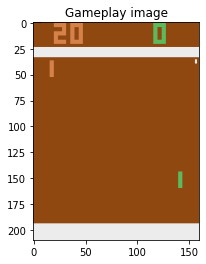

Episode: 30 /2000000 Timestep: 27351 Total reward: -19.8 Episode length: 964.3 Epsilon: 0.93 Loss: 103.1094


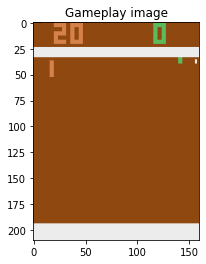

Episode: 40 /2000000 Timestep: 36869 Total reward: -20.1 Episode length: 951.8 Epsilon: 0.91 Loss: 92.7022


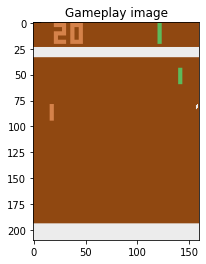

Episode: 50 /2000000 Timestep: 46469 Total reward: -20.0 Episode length: 960.0 Epsilon: 0.88 Loss: 87.5932


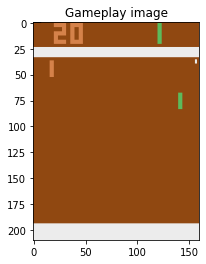

Episode: 60 /2000000 Timestep: 55738 Total reward: -20.2 Episode length: 926.9 Epsilon: 0.86 Loss: 68.3967


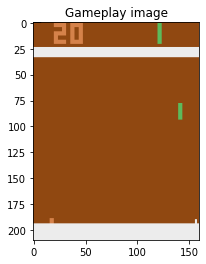

Episode: 70 /2000000 Timestep: 65240 Total reward: -20.2 Episode length: 950.2 Epsilon: 0.84 Loss: 46.9218


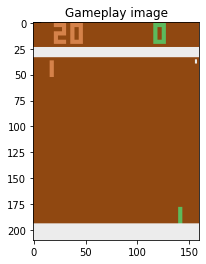

Episode: 80 /2000000 Timestep: 74140 Total reward: -20.2 Episode length: 890.0 Epsilon: 0.82 Loss: 33.9730


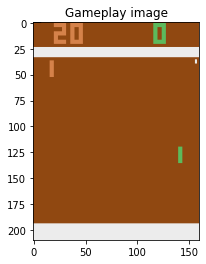

Episode: 90 /2000000 Timestep: 82901 Total reward: -20.4 Episode length: 876.1 Epsilon: 0.79 Loss: 30.6638


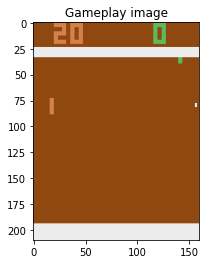

Episode: 100 /2000000 Timestep: 92101 Total reward: -20.3 Episode length: 920.0 Epsilon: 0.77 Loss: 29.6920


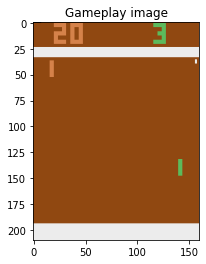

Episode: 110 /2000000 Timestep: 102195 Total reward: -20.0 Episode length: 1009.4 Epsilon: 0.75 Loss: 31.0526


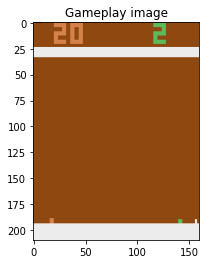

Episode: 120 /2000000 Timestep: 110924 Total reward: -20.4 Episode length: 872.9 Epsilon: 0.73 Loss: 28.4500


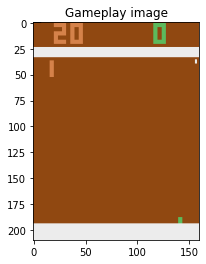

Episode: 130 /2000000 Timestep: 120481 Total reward: -20.0 Episode length: 955.7 Epsilon: 0.70 Loss: 33.8790


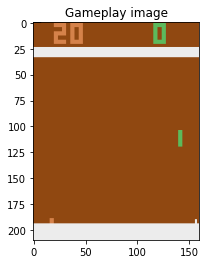

Episode: 140 /2000000 Timestep: 129129 Total reward: -20.8 Episode length: 864.8 Epsilon: 0.68 Loss: 30.8739


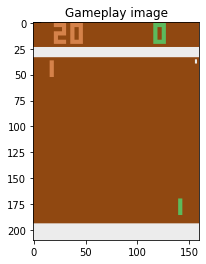

Episode: 150 /2000000 Timestep: 138119 Total reward: -20.5 Episode length: 899.0 Epsilon: 0.66 Loss: 31.6648


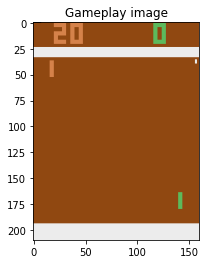

Episode: 160 /2000000 Timestep: 146925 Total reward: -20.4 Episode length: 880.6 Epsilon: 0.64 Loss: 29.7401


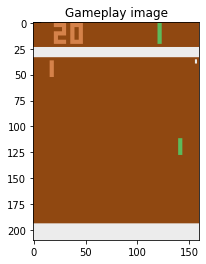

Episode: 170 /2000000 Timestep: 155543 Total reward: -20.7 Episode length: 861.8 Epsilon: 0.62 Loss: 29.6225


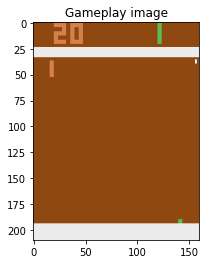

Episode: 180 /2000000 Timestep: 164414 Total reward: -20.1 Episode length: 887.1 Epsilon: 0.59 Loss: 31.3246


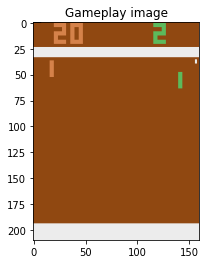

Episode: 190 /2000000 Timestep: 173694 Total reward: -20.5 Episode length: 928.0 Epsilon: 0.57 Loss: 33.7418


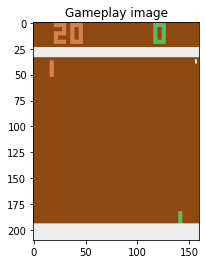

Episode: 200 /2000000 Timestep: 182411 Total reward: -20.1 Episode length: 871.7 Epsilon: 0.55 Loss: 33.6182


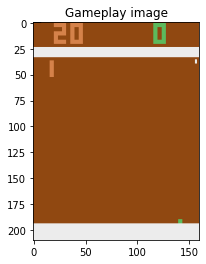

Episode: 210 /2000000 Timestep: 191473 Total reward: -20.5 Episode length: 906.2 Epsilon: 0.53 Loss: 36.0063


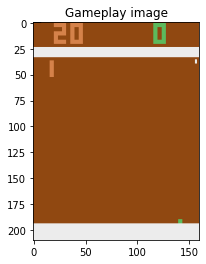

Episode: 220 /2000000 Timestep: 200268 Total reward: -20.5 Episode length: 879.5 Epsilon: 0.50 Loss: 35.9290


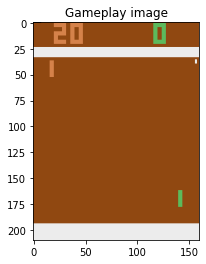

Episode: 230 /2000000 Timestep: 209382 Total reward: -20.3 Episode length: 911.4 Epsilon: 0.48 Loss: 36.6876


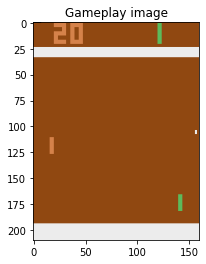

Episode: 240 /2000000 Timestep: 218297 Total reward: -20.5 Episode length: 891.5 Epsilon: 0.46 Loss: 36.3547


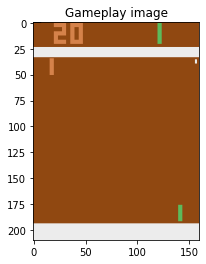

Episode: 250 /2000000 Timestep: 227040 Total reward: -20.7 Episode length: 874.3 Epsilon: 0.44 Loss: 36.1426


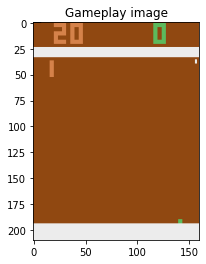

Episode: 260 /2000000 Timestep: 237457 Total reward: -19.6 Episode length: 1041.7 Epsilon: 0.41 Loss: 43.6891


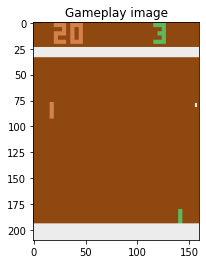

Episode: 270 /2000000 Timestep: 248945 Total reward: -19.7 Episode length: 1148.8 Epsilon: 0.38 Loss: 49.9990


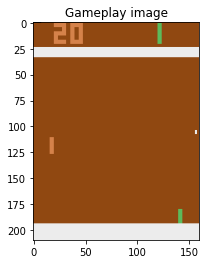

Episode: 280 /2000000 Timestep: 261039 Total reward: -19.7 Episode length: 1209.4 Epsilon: 0.35 Loss: 54.5473


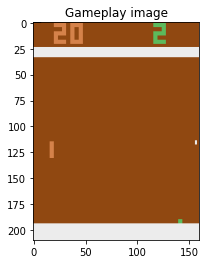

Episode: 290 /2000000 Timestep: 275836 Total reward: -18.3 Episode length: 1479.7 Epsilon: 0.32 Loss: 71.6720


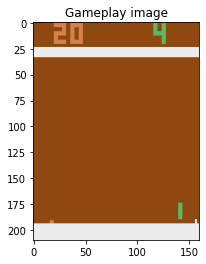

Episode: 300 /2000000 Timestep: 290371 Total reward: -19.5 Episode length: 1453.5 Epsilon: 0.28 Loss: 71.9109


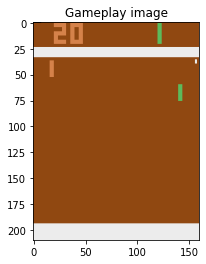

Episode: 310 /2000000 Timestep: 306493 Total reward: -18.9 Episode length: 1612.2 Epsilon: 0.24 Loss: 79.3118


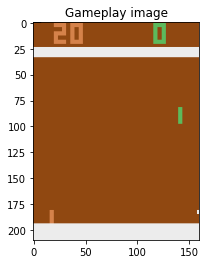

Episode: 320 /2000000 Timestep: 322493 Total reward: -18.7 Episode length: 1600.0 Epsilon: 0.20 Loss: 78.1485


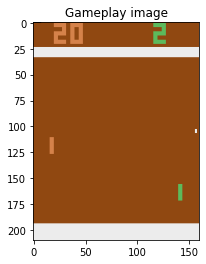

Episode: 330 /2000000 Timestep: 339300 Total reward: -19.4 Episode length: 1680.7 Epsilon: 0.16 Loss: 79.2353


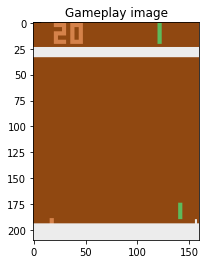

Episode: 340 /2000000 Timestep: 355942 Total reward: -19.1 Episode length: 1664.2 Epsilon: 0.12 Loss: 74.1441


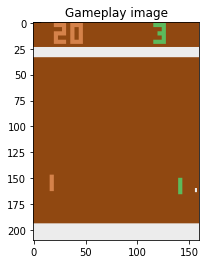

Episode: 350 /2000000 Timestep: 375227 Total reward: -18.5 Episode length: 1928.5 Epsilon: 0.07 Loss: 79.6189


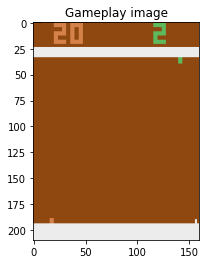

Episode: 360 /2000000 Timestep: 395022 Total reward: -18.3 Episode length: 1979.5 Epsilon: 0.02 Loss: 76.3643


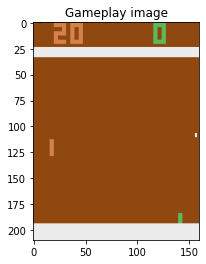

Episode: 370 /2000000 Timestep: 413856 Total reward: -19.5 Episode length: 1883.4 Epsilon: 0.01 Loss: 66.9033


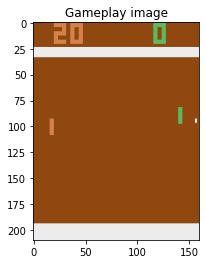

Episode: 380 /2000000 Timestep: 432737 Total reward: -18.9 Episode length: 1888.1 Epsilon: 0.01 Loss: 61.0788


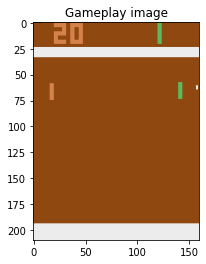

Episode: 390 /2000000 Timestep: 454098 Total reward: -19.4 Episode length: 2136.1 Epsilon: 0.01 Loss: 62.4398


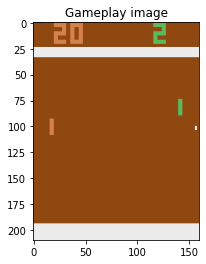

Episode: 400 /2000000 Timestep: 478238 Total reward: -19.3 Episode length: 2414.0 Epsilon: 0.01 Loss: 64.3856


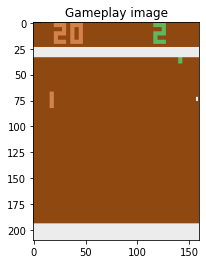

Episode: 410 /2000000 Timestep: 502868 Total reward: -18.9 Episode length: 2463.0 Epsilon: 0.01 Loss: 58.8333


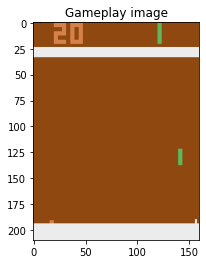

Episode: 420 /2000000 Timestep: 527301 Total reward: -18.8 Episode length: 2443.3 Epsilon: 0.01 Loss: 55.0484


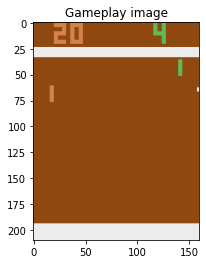

Episode: 430 /2000000 Timestep: 550554 Total reward: -18.3 Episode length: 2325.3 Epsilon: 0.01 Loss: 50.8429


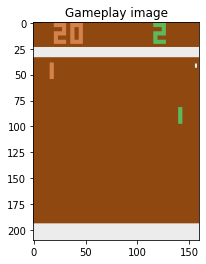

Episode: 440 /2000000 Timestep: 576157 Total reward: -18.2 Episode length: 2560.3 Epsilon: 0.01 Loss: 54.9215


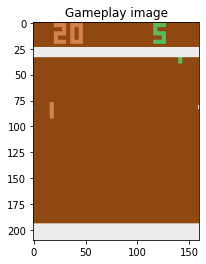

Episode: 450 /2000000 Timestep: 604525 Total reward: -17.9 Episode length: 2836.8 Epsilon: 0.01 Loss: 59.9076


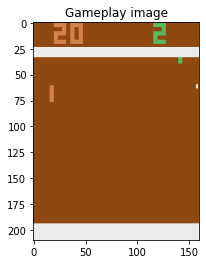

Episode: 460 /2000000 Timestep: 633789 Total reward: -18.0 Episode length: 2926.4 Epsilon: 0.01 Loss: 61.4287


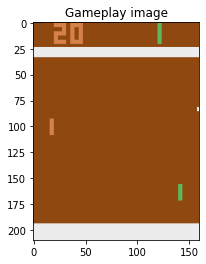

Episode: 470 /2000000 Timestep: 667835 Total reward: -18.6 Episode length: 3404.6 Epsilon: 0.01 Loss: 67.4857


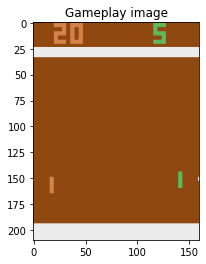

Episode: 480 /2000000 Timestep: 702983 Total reward: -17.8 Episode length: 3514.8 Epsilon: 0.01 Loss: 68.8172


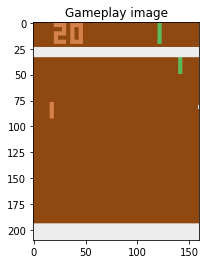

Episode: 490 /2000000 Timestep: 735200 Total reward: -15.8 Episode length: 3221.7 Epsilon: 0.01 Loss: 62.0680


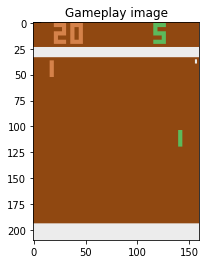

Episode: 500 /2000000 Timestep: 764378 Total reward: -16.9 Episode length: 2917.8 Epsilon: 0.01 Loss: 57.4620


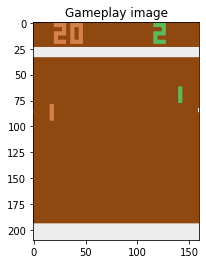

Episode: 510 /2000000 Timestep: 795027 Total reward: -17.0 Episode length: 3064.9 Epsilon: 0.01 Loss: 64.2286


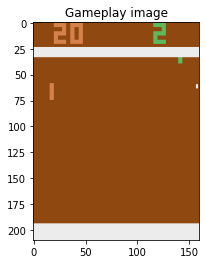

Episode: 520 /2000000 Timestep: 826716 Total reward: -18.0 Episode length: 3168.9 Epsilon: 0.01 Loss: 68.1041


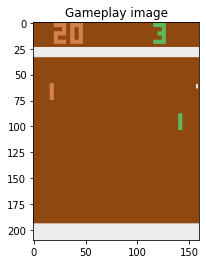

Episode: 530 /2000000 Timestep: 861966 Total reward: -15.4 Episode length: 3525.0 Epsilon: 0.01 Loss: 75.4701


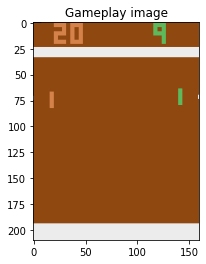

Episode: 540 /2000000 Timestep: 903712 Total reward: -11.4 Episode length: 4174.6 Epsilon: 0.01 Loss: 88.1974


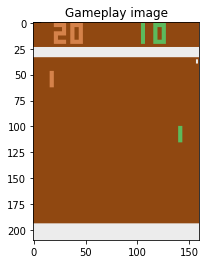

Episode: 550 /2000000 Timestep: 947862 Total reward: -9.4 Episode length: 4415.0 Epsilon: 0.01 Loss: 90.7024


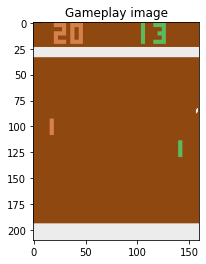

Episode: 560 /2000000 Timestep: 998552 Total reward: -6.8 Episode length: 5069.0 Epsilon: 0.01 Loss: 96.3919


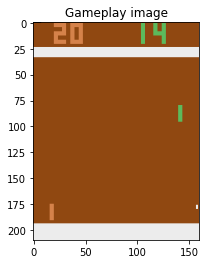

Episode: 570 /2000000 Timestep: 1047913 Total reward: -7.5 Episode length: 4936.1 Epsilon: 0.01 Loss: 89.8896


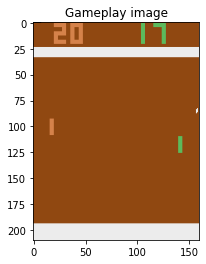

Episode: 580 /2000000 Timestep: 1096870 Total reward: -8.9 Episode length: 4895.7 Epsilon: 0.01 Loss: 91.6799


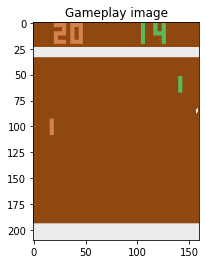

Episode: 590 /2000000 Timestep: 1144083 Total reward: -2.6 Episode length: 4721.3 Epsilon: 0.01 Loss: 90.3958


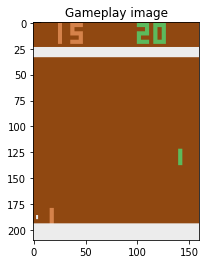

Episode: 600 /2000000 Timestep: 1196226 Total reward: -6.0 Episode length: 5214.3 Epsilon: 0.01 Loss: 98.9075


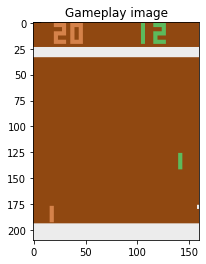

Episode: 610 /2000000 Timestep: 1249271 Total reward: -3.3 Episode length: 5304.5 Epsilon: 0.01 Loss: 100.8147


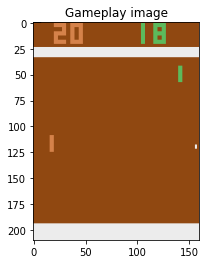

Episode: 620 /2000000 Timestep: 1300340 Total reward: -2.4 Episode length: 5106.9 Epsilon: 0.01 Loss: 90.6616


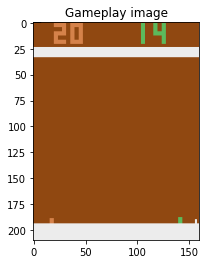

Episode: 630 /2000000 Timestep: 1343734 Total reward: 5.6 Episode length: 4339.4 Epsilon: 0.01 Loss: 72.3463


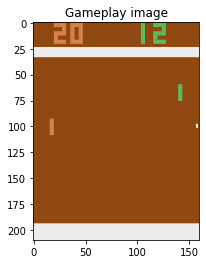

Episode: 640 /2000000 Timestep: 1376737 Total reward: 11.8 Episode length: 3300.3 Epsilon: 0.01 Loss: 53.4088


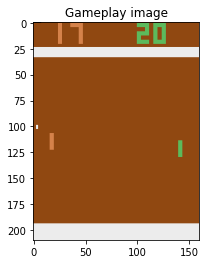

Episode: 650 /2000000 Timestep: 1406670 Total reward: 14.2 Episode length: 2993.3 Epsilon: 0.01 Loss: 46.5726


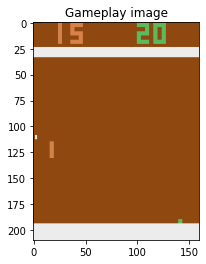

Episode: 660 /2000000 Timestep: 1433100 Total reward: 16.3 Episode length: 2643.0 Epsilon: 0.01 Loss: 38.5456


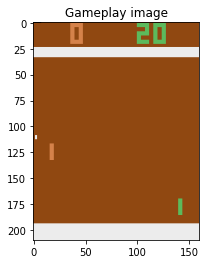

Episode: 670 /2000000 Timestep: 1456224 Total reward: 17.3 Episode length: 2312.4 Epsilon: 0.01 Loss: 28.9325


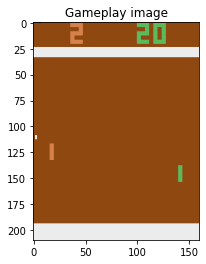

Episode: 680 /2000000 Timestep: 1477556 Total reward: 18.7 Episode length: 2133.2 Epsilon: 0.01 Loss: 21.6750


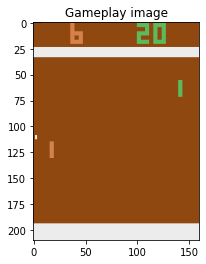

Episode: 690 /2000000 Timestep: 1500092 Total reward: 17.9 Episode length: 2253.6 Epsilon: 0.01 Loss: 20.8480


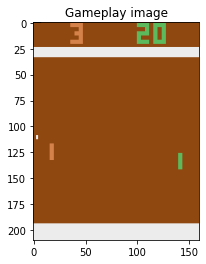

Episode: 700 /2000000 Timestep: 1521468 Total reward: 19.1 Episode length: 2137.6 Epsilon: 0.01 Loss: 16.8814


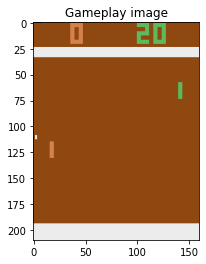

Episode: 710 /2000000 Timestep: 1541917 Total reward: 19.0 Episode length: 2044.9 Epsilon: 0.01 Loss: 15.2129


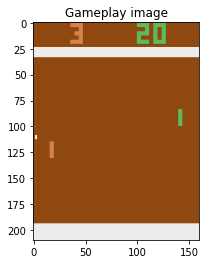

Episode: 720 /2000000 Timestep: 1563321 Total reward: 18.6 Episode length: 2140.4 Epsilon: 0.01 Loss: 15.2570


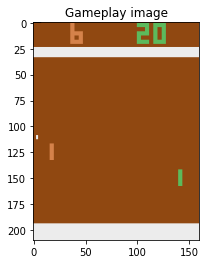

Episode: 730 /2000000 Timestep: 1583909 Total reward: 19.0 Episode length: 2058.8 Epsilon: 0.01 Loss: 13.9162


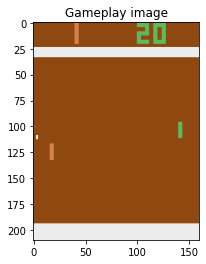

Episode: 740 /2000000 Timestep: 1605175 Total reward: 18.3 Episode length: 2126.6 Epsilon: 0.01 Loss: 13.2909


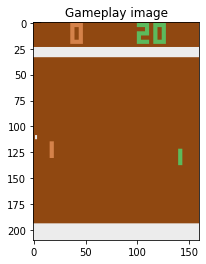

In [ ]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
episode = 1
episode_length = 0
stats_loss = 0.
epsilon = epsilon_start
state = env.reset()
td_loss_history = []

for ts in range(timesteps):
    #env.render()
    # select an action from the agent's policy
    action = dqn_agent.select_action(state, epsilon)
    # decay epsilon
    epsilon -= epsilon_step
    if epsilon < epsilon_min:
        epsilon = epsilon_min
            
    # enter action into the env
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    episode_length += 1
    
    # add experience to replay buffer
    replay_buffer.add((state, next_state, action, reward, float(done)))
    
    if ts > start_training_after:
        # train the agent
        stats_loss += dqn_agent.train(replay_buffer, batch_size, discount)
        td_loss_history.append(stats_loss)
        
        # update the target network every (if conditions are met in update_target_network)
        #dqn_agent.update_target_network(ts, update_target_every) # hard target update
        dqn_agent.update_target_network_soft(ts, update_target_every, tau) # soft target update
    
    if done:
        screen = env.render(mode='rgb_array')
        state = env.reset()
        stats_rewards_list.append((episode, total_reward, episode_length))
        episode += 1
        total_reward = 0
        episode_length = 0

        if ts > start_training_after and episode % stats_every == 0:
            print('Episode: {}'.format(episode),
                  '/{}'.format(timesteps),
                'Timestep: {}'.format(ts),
                'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                'Epsilon: {:.2f}'.format(epsilon),
                'Loss: {:.4f}'.format(stats_loss))
            stats_loss = 0.
            
            # Plotting Screenshot
            plt.title("Gameplay image")
            plt.imshow(screen)
            plt.show()
        
        # stopping condition for training if agent reaches the amount of reward
        if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 20:
            print("Stopping at episode {} with average rewards of {} in last {} episodes".
                format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
            
            # Plotting Screenshot
            plt.title("Gameplay image")
            plt.imshow(screen)
            plt.show()
            break  
    else:
        state = next_state
    

### Plotting graphs

Text(0, 0.5, 'Episode Reward')

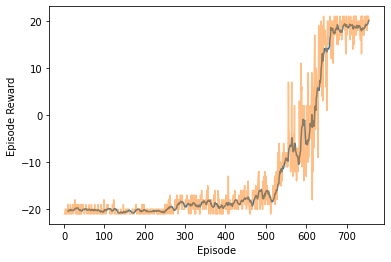

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

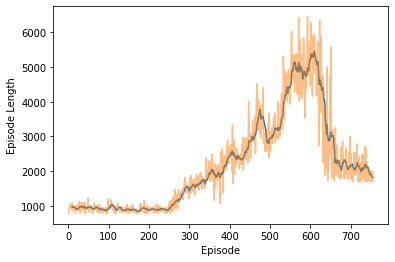

In [ ]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

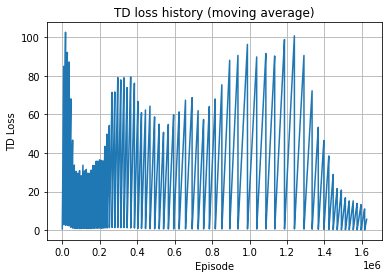

In [ ]:
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
# Plot TD loss history
plt.title("TD loss history (moving average)")
plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.grid()

### Video

In [ ]:
def show_video():
  """Enables video recording of gym environment and shows it."""
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Video not found")
    

def wrap_environment(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
env = make_env()

# Wrap the environment by using Monitor
env = wrap_environment(env)

# reset epsilon back to previous value if we want to contuniue the training
epsilon = 0.01

state = env.reset()

for i in range(10000):
    env.render("rgb_array")
    action = dqn_agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    if done:
        env.reset()
    else:
      state = next_state
env.close()
show_video()